In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from enum import Enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *

# Classification

## Loading Datasets

In [2]:
class DF( Enum ):
    _10SEC = 'gym-10sec'
    _10SEC_AVG = 'gym-10sec-avg'
    _30SEC = 'gym-30sec'
    _30SEC_AVG = 'gym-30sec-avg'
    _1MIN = 'gym-1min'
    _1MIN_AVG = 'gym-1min-avg'
    _5MIN = 'gym-5min'
    _5MIN_AVG = 'gym-5min-avg'
    
# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'resolutions' ]

df = {}
for k in DF :
    temp = [ None ] * 2
    temp[ 0 ] = pd.read_csv( os.path.join( *path, 'ds-%s-train.csv' % k.value ), index_col = 'date', parse_dates = [ 'date' ] )
    temp[ 1 ] = pd.read_csv( os.path.join( *path, 'ds-%s-test.csv' % k.value ), index_col = 'date', parse_dates = [ 'date' ] )
    df[ k ] = temp

## Data splitting, standarization and balancing

In [3]:
from imblearn.over_sampling import ADASYN
from collections import Counter


# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._10SEC: 9,
    DF._10SEC_AVG: 9,
    DF._30SEC: 9,
    DF._30SEC_AVG: 9,
    DF._1MIN: 3,
    DF._1MIN_AVG: 3,
    DF._5MIN: 3,
    DF._5MIN_AVG: 4
}

for k, d in df.items():
    temp = [ 
        d[ 0 ].drop( 'occ', axis = 1 ), # x train
        d[ 1 ].drop( 'occ', axis = 1 ), # x test
        d[ 0 ].occ, # y train
        d[ 1 ].occ ] # y test
    
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )

    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ],
        temp[ Y_TRAIN ],
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    df[ k ] = temp

Before balancing: DF._10SEC Counter({'M': 430, 'L': 202, 'H': 189})
After balancing: DF._10SEC Counter({'M': 430, 'H': 430, 'L': 430})

Before balancing: DF._10SEC_AVG Counter({'M': 430, 'L': 202, 'H': 189})
After balancing: DF._10SEC_AVG Counter({'M': 430, 'H': 430, 'L': 430})

Before balancing: DF._30SEC Counter({'M': 149, 'L': 72, 'H': 59})
After balancing: DF._30SEC Counter({'H': 150, 'L': 149, 'M': 149})

Before balancing: DF._30SEC_AVG Counter({'M': 149, 'L': 72, 'H': 59})
After balancing: DF._30SEC_AVG Counter({'L': 149, 'M': 149, 'H': 149})

Before balancing: DF._1MIN Counter({'M': 77, 'H': 34, 'L': 33})
After balancing: DF._1MIN Counter({'M': 77, 'H': 77, 'L': 77})

Before balancing: DF._1MIN_AVG Counter({'M': 77, 'H': 34, 'L': 33})
After balancing: DF._1MIN_AVG Counter({'M': 77, 'H': 77, 'L': 77})

Before balancing: DF._5MIN Counter({'M': 21, 'L': 9, 'H': 5})
After balancing: DF._5MIN Counter({'L': 21, 'M': 21, 'H': 21})

Before balancing: DF._5MIN_AVG Counter({'M': 21, 'L': 

## Training

In [4]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from ml.classification import *

params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 4, 6, 8, 10, 12, 14, 16, 18 ]
} ]

grids = {}
labels = [ 'H', 'L', 'M' ]
exclude = []

### Regular

Dataset  DF._10SEC
Best params:  {'criterion': 'entropy', 'max_depth': 8}
Training Accuracy 0.9976744186046511
Test Accuracy:  1.0
Test ROCauc (OvR): 1.0

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      1.00      1.00        50
           L       1.00      1.00      1.00        45
           M       1.00      1.00      1.00       111

    accuracy                           1.00       206
   macro avg       1.00      1.00      1.00       206
weighted avg       1.00      1.00      1.00       206


Dataset  DF._10SEC_AVG
Best params:  {'criterion': 'entropy', 'max_depth': 10}
Training Accuracy 0.9984496124031008
Test Accuracy:  0.9902912621359223
Test ROCauc (OvR): 0.9898245614035087

Detailed Classification Report
              precision    recall  f1-score   support

           H       1.00      0.96      0.98        50
           L       1.00      1.00      1.00        45
           M       0.98      1.00      0.99     

/Users/Andree/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best params:  {'criterion': 'gini', 'max_depth': 18}
Training Accuracy 0.8798076923076925
Test Accuracy:  0.8888888888888888
Test ROCauc (OvR): 0.9027777777777777

Detailed Classification Report
              precision    recall  f1-score   support

           H       0.83      1.00      0.91         5
           L       1.00      1.00      1.00         1
           M       1.00      0.67      0.80         3

    accuracy                           0.89         9
   macro avg       0.94      0.89      0.90         9
weighted avg       0.91      0.89      0.88         9


CPU times: user 8.54 s, sys: 500 ms, total: 9.04 s
Wall time: 7.36 s


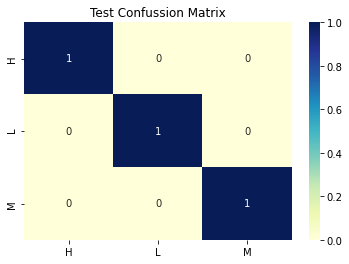

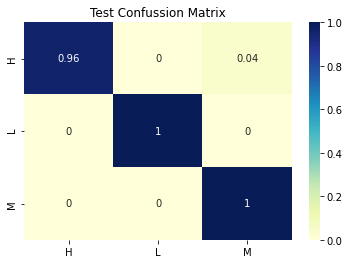

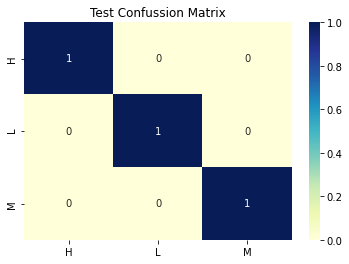

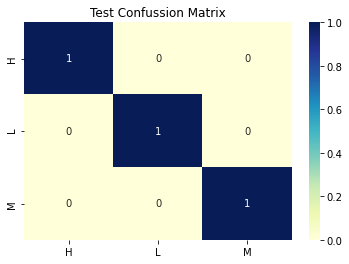

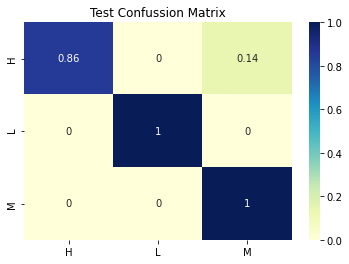

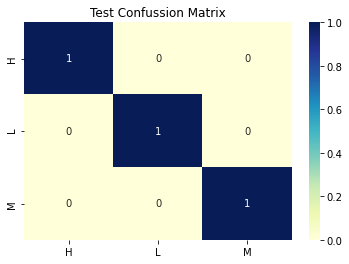

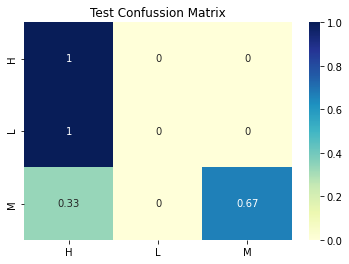

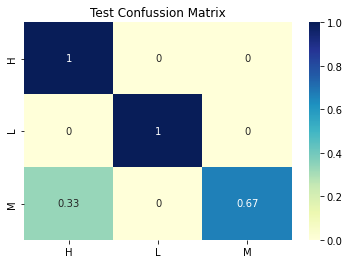

In [5]:
%%time
for k, d in df.items():
    if( k not in exclude ):
        print( 'Dataset ', k )
        grids[ k ] = train_and_test( 
                DecisionTreeClassifier(), params_dt, 
                d[ X_TRAIN ], d[ Y_TRAIN ], 
                d[ X_TEST ], d[ Y_TEST ], 
                plot_cmatrix = True, labels = labels )

In [8]:
y_pred = grids[ DF._5MIN ].best_estimator_.predict(  df[ DF._5MIN ][ X_TEST ] )
y_pred

array(['H', 'M', 'H', 'H', 'H', 'H', 'H', 'H', 'M'], dtype=object)

In [9]:
y_true = df[ DF._5MIN ][ Y_TEST ].values
y_true

array(['L', 'M', 'H', 'M', 'H', 'H', 'H', 'H', 'M'], dtype=object)

In [10]:
from sklearn.metrics import classification_report, accuracy_score

print( accuracy_score( y_pred, y_true ) )
print( classification_report( y_pred,  y_true ) )

0.7777777777777778
              precision    recall  f1-score   support

           H       1.00      0.71      0.83         7
           L       0.00      0.00      0.00         0
           M       0.67      1.00      0.80         2

    accuracy                           0.78         9
   macro avg       0.56      0.57      0.54         9
weighted avg       0.93      0.78      0.83         9



/Users/Andree/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Evaluation

In [6]:
from ml.evaluation import *

## Learning Curves

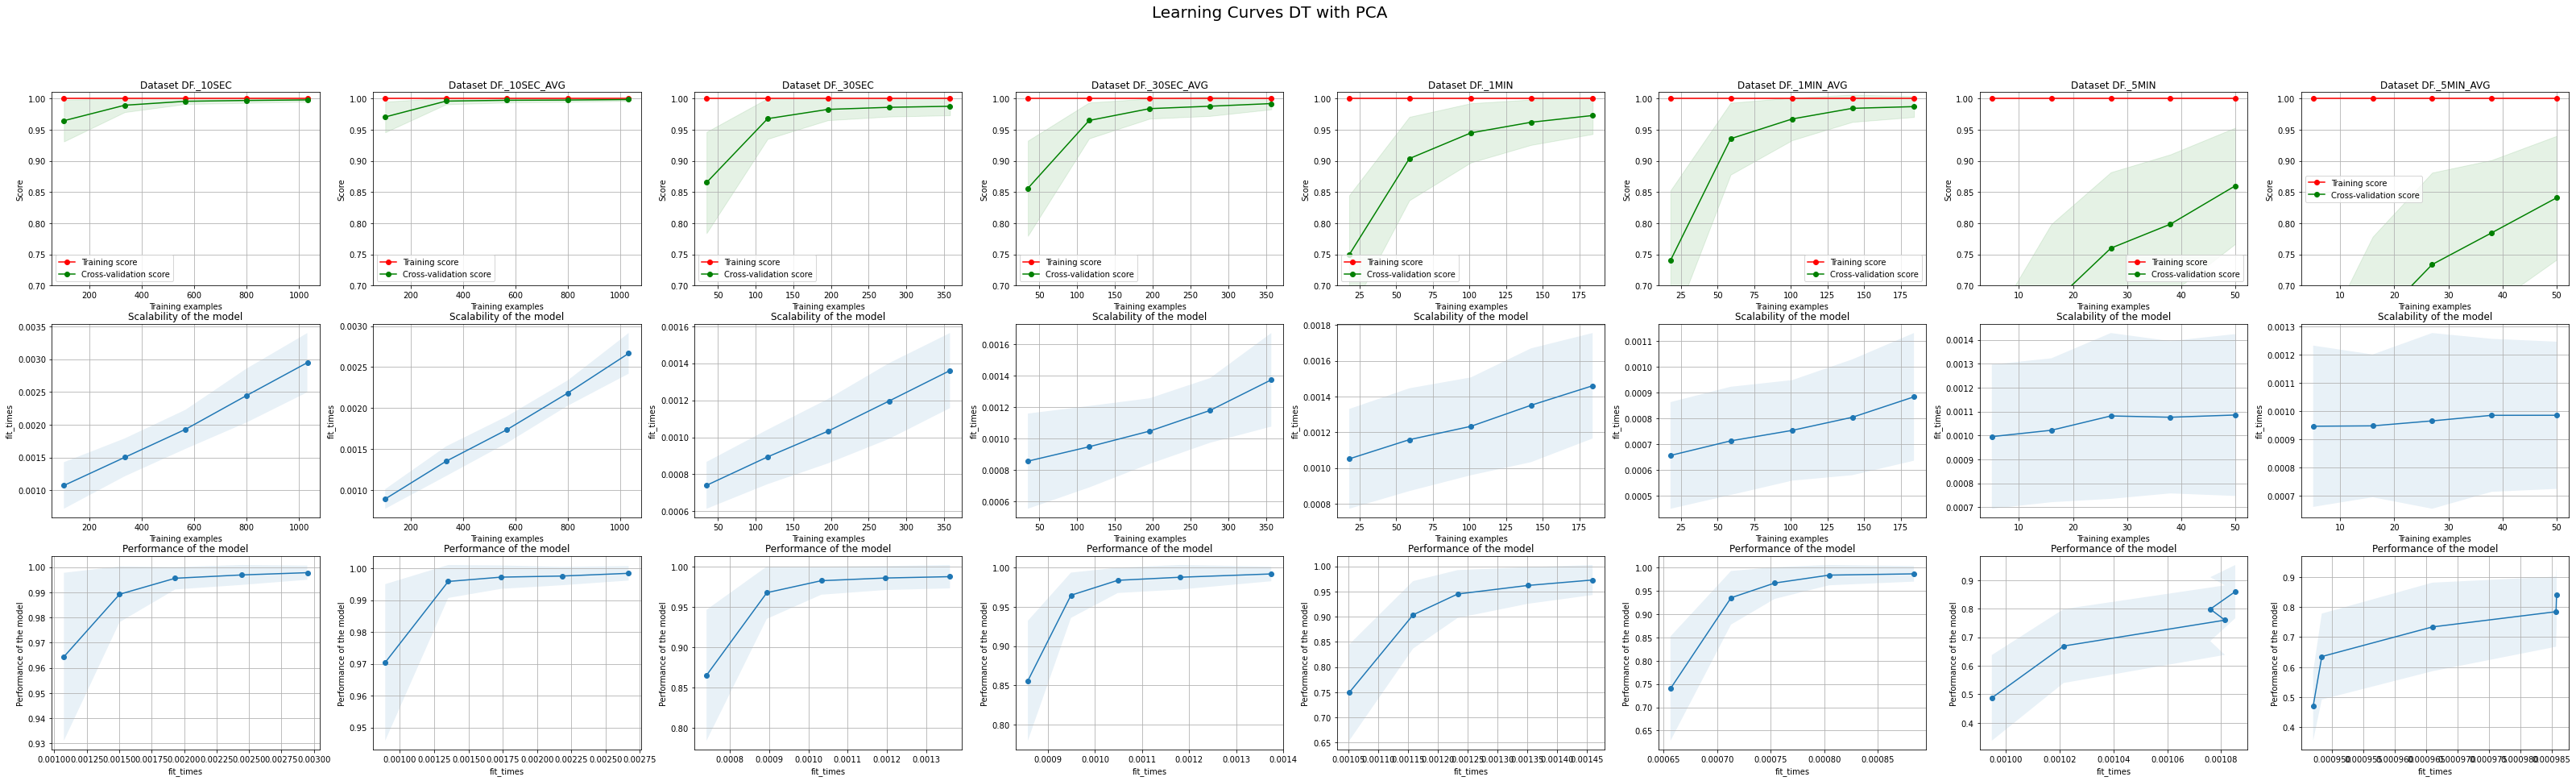

CPU times: user 9.17 s, sys: 600 ms, total: 9.77 s
Wall time: 10.4 s


In [7]:
%%time
temp = [ item for item in df.items() if item[ 0 ] not in [  ] ]
plot_learning_curves( temp, grids, 'DT' )